## WiSD Summer 2023 Hackathon: 
# Comparing per Position Predictions of Made Shots Location Metrics

Hi! I'm Katherine Comer, a rising sophomore at the University of Pennsylvania studying Business Analytics in Wharton. 

For my project, I sought out to discover if there is a relationship between a player's position, how open their shot was, how far their shot was, and how likely the player was to make their shot.

Generally, I wanted to answer the question if some positions are better at making open shots that others, or if how closely a shooter is being defended and/or how long the shot was has any impact on the probablity of them making the shot.

## Data Acquistion

First, I imported the relevant packages and modules.

In [63]:
#import packages
import boto3
import pandas as pd
import numpy as np
from statistics import mean
import math
import seaborn as sns
from sklearn.linear_model import LogisticRegression

The data I analyzed was from the 2021-2022 NBA Conference Finals and League Finals. Each game had:

~ tracking data, that included of location data for all on court players and the ball, for around 96,600 frames per game

~ event data, that included event type of each action (dribble, shot, pass, etc.), the players who committed the action, the players on the court, etc.

I was also given player data that contained information about every player's position, height, etc.

In [ ]:
#access nba tracking, event, and player data:
s3_client = boto3.client('s3', 
                         aws_access_key_id=[access_key], 
                         aws_secret_access_key=[secret_access_key])

#download data to folder (pulling from a list of 18 game ids):
game_ids = ["0042100301",
    "0042100302",
    "0042100303",
    "0042100304",
    "0042100305",
    "0042100306",
    "0042100307",
    "0042100311",
    "0042100312",
    "0042100313",
    "0042100314",
    #"0042100315", (will be used to test our logisitical regression model later)
    "0042100401",
    "0042100402",
    "0042100403",
    "0042100404",
    "0042100405",
    "0042100406"]

for i in range(len(game_ids)):
    #events
    gameid = game_ids[i]
    key = "games/{}/{}_events.jsonl".format(gameid, gameid)
    filename = "{}_events.jsonl".format(gameid)
    s3_client.download_file(Bucket =[bucket], 
                        Key = key, 
                        Filename = filename)
    #tracking
    key = "games/{}/{}_tracking.jsonl".format(gameid, gameid)
    filename = "{}_tracking.jsonl".format(gameid)
    s3_client.download_file(Bucket =[bucket], 
                        Key = key, 
                        Filename = filename)
    
#player
s3_client.download_file(Bucket =[bucket], 
                        Key = [key], 
                        Filename = "players.jsonl")

In [ ]:
#access supplmentary nba play by play data (directions provided by WiSD github)
for gameid in game_ids:
    HEADERS = {'Connection': 'keep-alive',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'x-nba-stats-token': 'true',
           'Accept-Language': 'en-US,en;q=0.9',
           "X-NewRelic-ID": "VQECWF5UChAHUlNTBwgBVw==",
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6)' +\
                         ' AppleWebKit/537.36 (KHTML, like Gecko)' + \
                         ' Chrome/81.0.4044.129 Safari/537.36'}

    game_id = gameid
    plays = playbyplay.PlayByPlay(headers=HEADERS,
                              endpoint='playbyplayv2',
                              game_id=game_id)

    play_df = pd.DataFrame(plays.data['PlayByPlay'])

    file_path = f"{game_id}_events.jsonl"

    with open(file_path, 'r') as f:
        json_list = list(f)

    event_list = []
    for json_str in json_list:
        result = json.loads(json_str)
        event_list.append(result)

    event_df = pd.DataFrame(event_list)

    joint_df = event_df.merge(play_df, left_on="pbpId", right_on="EVENTNUM", how="left")
    
    #specific columns were picked out for the purposes of my project
    pbp = joint_df[['gameId', 'eventType', 'shotClock', 'gameClock', 'wallClock', 'period',
       'homePlayers', 'awayPlayers', 'playerId', 'pbpId', 'GAME_ID',
       'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGACTIONTYPE', 'PERIOD',
       'WCTIMESTRING', 'PCTIMESTRING', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION',
       'VISITORDESCRIPTION', 'SCORE']]
    
    #download pbp data to folder
    pbp.to_json("{}_pbp.jsonl".format(gameid))

I needed to only look at the data surrounding each shot from every game given. I created a function that took in a game id and gathered the location data of the shooter and every defensive player (to find the closest defender to the shooter at the time of the shot), the distance the shooter was to the center of the hoop at the time of the shot, and whether or not the shot was made. 

In [127]:
#create a function that takes in a game id
def collect(gameid):
    #0 create data storage:
    
    shots_data = pd.DataFrame({
    'game_id': [],
    'shooter_id': [],
    'shot_time': [],
    'shot_dist': [],
    'min_dist': [],
    'make=1': []
    })

    #1 load data:
    
    events = pd.read_json("{}_events.jsonl".format(gameid), lines=True)
    track = pd.read_json("{}_tracking.jsonl".format(gameid), lines=True)
    pbp = pd.read_json("{}_pbp.jsonl".format(gameid))
    
    #1b merge dataframes into one:
    
    game = pd.merge(pd.merge(events,track,on='wallClock'),pbp,on='wallClock')
    
    #2 filter to obtain only data about shots:
    
    game_shots = game.loc[game.eventType_x=="SHOT"]
    with pd.option_context('mode.chained_assignment', None): #error supression
        #below to meant to ease working around [None] dataframe cells
        game_shots.HOMEDESCRIPTION.replace(to_replace=[None], value="No Description", inplace=True)
        game_shots.VISITORDESCRIPTION.replace(to_replace=[None], value="No Description", inplace=True)
        #to remove shots with fouls, etc.
        game_shots = game_shots.loc[(game_shots["EVENTMSGTYPE"]==1) | (game_shots["EVENTMSGTYPE"]==2)]
    
    #3 retrieve shooter ids, shot times, and shot locations:
    
    shooter_ids = game_shots.playerId_x
    shot_times = game_shots.wallClock
    shot_locations = track.loc[track.wallClock.isin(shot_times)]
    
    #4 determining openness of shot for each shot in game_shots:
    
    for shot in range(len(game_shots)):
        
    #4a getting shooter's location:
        
        shooter_loc = "NaN"

        while shooter_loc == "NaN":
            for player in range(5):
                if shot_locations["awayPlayers"].iloc[shot][player]['playerId'] == shooter_ids.iloc[shot]:
                    shooter_loc = shot_locations["awayPlayers"].iloc[shot][player]['xyz']
                    shooter_team = "away"
            for player in range(5):
                if shot_locations["homePlayers"].iloc[shot][player]['playerId'] == shooter_ids.iloc[shot]:
                    shooter_loc = shot_locations["homePlayers"].iloc[shot][player]['xyz']
                    shooter_team = "home"
    
    #4b getting defensive player's locations:
        
        defense_loc = []

        if shooter_team == "home":
            for player in range(5):
                defense_loc.append(shot_locations["awayPlayers"].iloc[shot][player]['xyz'])
        if shooter_team == "away":
            for player in range(5):
                defense_loc.append(shot_locations["homePlayers"].iloc[shot][player]['xyz'])
        
    #4c getting min distance between defense and player:
    
        defense_dist = []
        
        for player in range(len(defense_loc)):
            d = defense_loc[player][0:2]
            s = shooter_loc[0:2]
            defense_dist.append(math.dist(d,s))
    
        min_dist = min(defense_dist)
        
    #4d getting shot distance
        
        if np.sign(shooter_loc[0]) == 1.0:
            h = [41.75,0]
            s = shooter_loc[0:2]
            shot_dist = math.dist(h,s)
        if np.sign(shooter_loc[0]) == -1.0:
            h = [-41.75,0]
            s = shooter_loc[0:2]
            shot_dist = math.dist(h,s)
            
    #5 did the player make the shot?
    
        if shooter_team == "home":
            if ("MISS" not in game_shots.HOMEDESCRIPTION.iloc[shot]) == True:
                status = 1
            elif ("MISS" not in game_shots.HOMEDESCRIPTION.iloc[shot]) == False:
                status = 0
        elif shooter_team == "away":
            if ("MISS" not in game_shots.VISITORDESCRIPTION.iloc[shot]) == True:
                status = 1
            elif ("MISS" not in game_shots.VISITORDESCRIPTION.iloc[shot]) == False:
                status = 0
            
    #6 add data to table:
        shots_data.loc[len(shots_data.index)] = [gameid, shooter_ids.iloc[shot], shot_times.iloc[shot], shot_dist, min_dist, status]
    
    #repeat for all shots in game_shots
                            
    return(shots_data)

In [128]:
#example
collect(game_ids[0])

,game_id,shooter_id,shot_time,shot_dist,min_dist,make=1
0,0042100301,561048bb-c412-4d8b-a0bc-27d250a1a431,1652834798699,24.367047,10.932017,1
1,0042100301,ff41362b-89ef-11e6-babd-a45e60e298d3,1652834818099,8.040759,4.088643,0
2,0042100301,986b713a-b20b-4eb0-919e-c859d0508af7,1652834835059,3.475759,4.298930,1
3,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652834850139,19.948032,3.671852,0
4,0042100301,a6904c1c-0dc5-41c8-a618-b3a276131726,1652834857499,2.161342,2.836935,0
...,...,...,...,...,...,...
154,0042100301,e77c0b40-1652-4d89-8daf-a2f6028938dd,1652844110219,3.639396,1.655204,0
155,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652844133579,25.142086,4.023593,0
156,0042100301,986b713a-b20b-4eb0-919e-c859d0508af7,1652844142099,3.580642,2.616295,0
157,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652844150579,2.298956,2.348829,1


I was unable to find a more efficient way of replicating this process in a way that could result in a large cumulative dataframe created by the function. So, a dataframe was created for each game, and they were merged manually.

In [129]:
#each game id was ran through the collect() function, and the resulting dataframe was assigned a letter

#conference finals games
a = collect(game_ids[0])
b = collect(game_ids[1])
c = collect(game_ids[2])
d = collect(game_ids[3])
e = collect(game_ids[4])
f = collect(game_ids[5])
g = collect(game_ids[6])
h = collect(game_ids[7])
i = collect(game_ids[8])
j = collect(game_ids[9])
conf_finals = pd.concat([a,b,c,d,e,f,g,h,i,j])

#nba finals games
k = collect(game_ids[10])
l = collect(game_ids[11])
m = collect(game_ids[12])
n = collect(game_ids[13])
o = collect(game_ids[14])
p = collect(game_ids[15])
q = collect(game_ids[16])
nba_finals = pd.concat([k,l,m,n,o,p,q])

#added some identifying columns for ease
conf_finals["round"] = "conference finals"
nba_finals["round"] = "nba finals"

#data was then merged to compiled into one large dataframe
all_data = pd.concat([conf_finals, nba_finals])
#game_id was also turned into a string for stat purposes
all_data["game_id"] = all_data["game_id"].apply(str)

#results
display(all_data.head())
print(all_data.shape)

,game_id,shooter_id,shot_time,shot_dist,min_dist,make=1,round
0,0042100301,561048bb-c412-4d8b-a0bc-27d250a1a431,1652834798699,24.367047,10.932017,1,conference finals
1,0042100301,ff41362b-89ef-11e6-babd-a45e60e298d3,1652834818099,8.040759,4.088643,0,conference finals
2,0042100301,986b713a-b20b-4eb0-919e-c859d0508af7,1652834835059,3.475759,4.298930,1,conference finals
3,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652834850139,19.948032,3.671852,0,conference finals
4,0042100301,a6904c1c-0dc5-41c8-a618-b3a276131726,1652834857499,2.161342,2.836935,0,conference finals


With the data above, I needed some player data to supplement it with information about each player's position, height, and name. These were added by matching the corresponding information in the players dataframe with the shooter id provided in all_data.

In [130]:
#load in the players data
players = pd.read_json("players.json")

#getting the player id for each shot
shooter_ids = all_data.shooter_id

#creating columns for information needed
all_data["shooter_position"] = "NaN"
all_data["shooter_height"] = "NaN"
all_data["shooter_last"] = "NaN"
all_data["shooter_first"] = "NaN"

#match each shooter id to the appropriate information found in the players dataframe, and add to all_data:
for shooter in range(len(shooter_ids)):
    for row in range(len(players)):
        if (shooter_ids.iloc[shooter] in players.iloc[row,0]["id"]) == True:
            with pd.option_context('mode.chained_assignment', None): #error supression
                all_data["shooter_position"].iloc[shooter] = players.iloc[row,0]["position"]
                all_data["shooter_height"].iloc[shooter] = players.iloc[row,0]["height"]
                all_data["shooter_last"].iloc[shooter] = players.iloc[row,0]["lastName"]
                all_data["shooter_first"].iloc[shooter] = players.iloc[row,0]["firstName"]

#for stat purposes
all_data["shooter_height"] = all_data["shooter_height"].apply(pd.to_numeric)
#results
display(all_data.head())
print(all_data.shape)

,game_id,shooter_id,shot_time,shot_dist,min_dist,make=1,round,shooter_position,shooter_height,shooter_last,shooter_first
0,0042100301,561048bb-c412-4d8b-a0bc-27d250a1a431,1652834798699,24.367047,10.932017,1,conference finals,F,78.0,Williams,Grant
1,0042100301,ff41362b-89ef-11e6-babd-a45e60e298d3,1652834818099,8.040759,4.088643,0,conference finals,F,77.0,Tucker,P.J.
2,0042100301,986b713a-b20b-4eb0-919e-c859d0508af7,1652834835059,3.475759,4.298930,1,conference finals,F-G,80.0,Tatum,Jayson
3,0042100301,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1652834850139,19.948032,3.671852,0,conference finals,F,79.0,Butler,Jimmy
4,0042100301,a6904c1c-0dc5-41c8-a618-b3a276131726,1652834857499,2.161342,2.836935,0,conference finals,G-F,78.0,Brown,Jaylen


(2814, 11)


## Exploratory Data Analysis (EDA)

Now, I had all the necessary data complied, cleaned, and standardized. Next, I performed some exploratory data analysis in order to get a general idea of any trend, patterns, or relationships in the data.

First, I grouped the data by position and took a look at how each position tends to be guarded and how far the shots they take tend to be.

In [132]:
all_data.groupby("shooter_position", as_index = False).agg({"min_dist":["mean", "std"], "shot_dist":["mean", "std"], "make=1":["mean"]})

#forwards are the least closely guarded position, while forward-centers have made the most of their shots and 
#have shot the closest.
#guard-type players made the least of their shots, while shooting the farthest shots
#and were generally guarded from closer than other positions, with the exception of centers.

shooter_position  min_dist            shot_dist              make=1
                        mean       std       mean       std      mean
0                C  3.908287  2.192573   8.109647  6.888420  0.562500
1              C-F  4.215862  2.400829   9.918310  8.603250  0.602679
2                F  5.006217  3.142767  13.372543  9.793365  0.466292
3              F-C  4.040568  1.770003   6.345944  7.688654  0.666667
4              F-G  4.045768  1.725674  15.680567  9.955273  0.418960
5                G  4.808732  2.600492  17.609253  9.769962  0.417399
6              G-F  4.394252  2.320611  17.328517  9.785709  0.410995

Next, I created a correlation table between the distance of the closest defender, the shot distance, and whether or not the shot was made.

In [133]:
all_data[["min_dist","shot_dist","make=1"]].corr()

#no significantly strong correlations between these variables, although min_dist and shot_dist 
#have the strongest correlation.

,min_dist,shot_dist,make=1
min_dist,1.000000,0.479039,-0.012418
shot_dist,0.479039,1.000000,-0.204967
make=1,-0.012418,-0.204967,1.000000


The following plots are sorted by shooter position and show the relationship between the distance of the closest defender and the shot distance, while also indicating whether or not the shot was made.

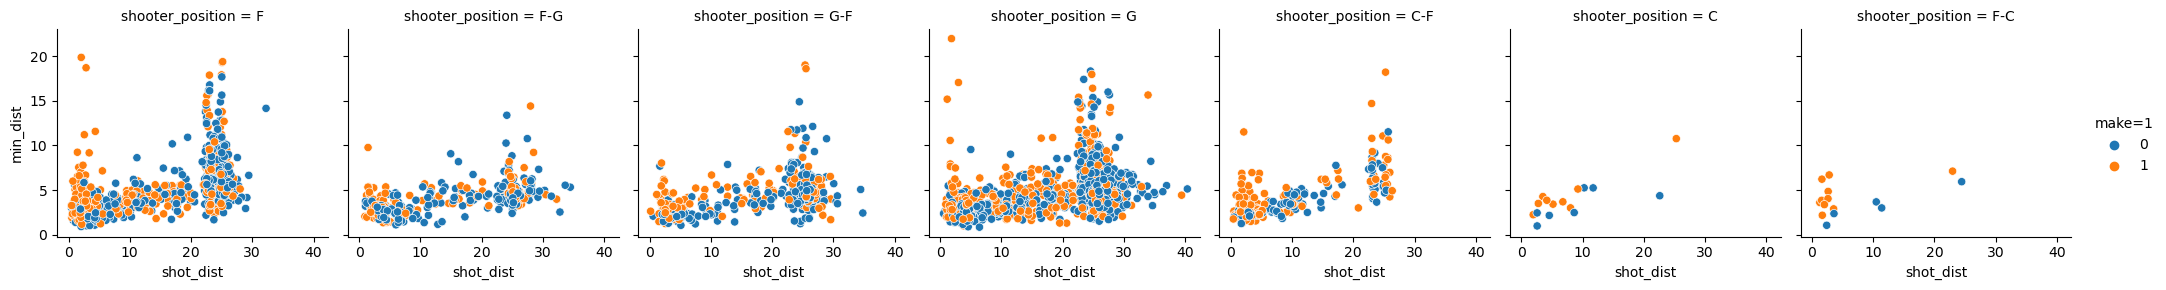

In [138]:
sns.relplot(x="shot_dist", y="min_dist", data=all_data, hue="make=1", col="shooter_position", height=3)

#all positions seem to have a pretty even spread of made and missed shots, regardless of distance, which is expected.

Finally, I ran a logistic regression on each player group to see how the distance of the closest defender determines whether the shot is made.

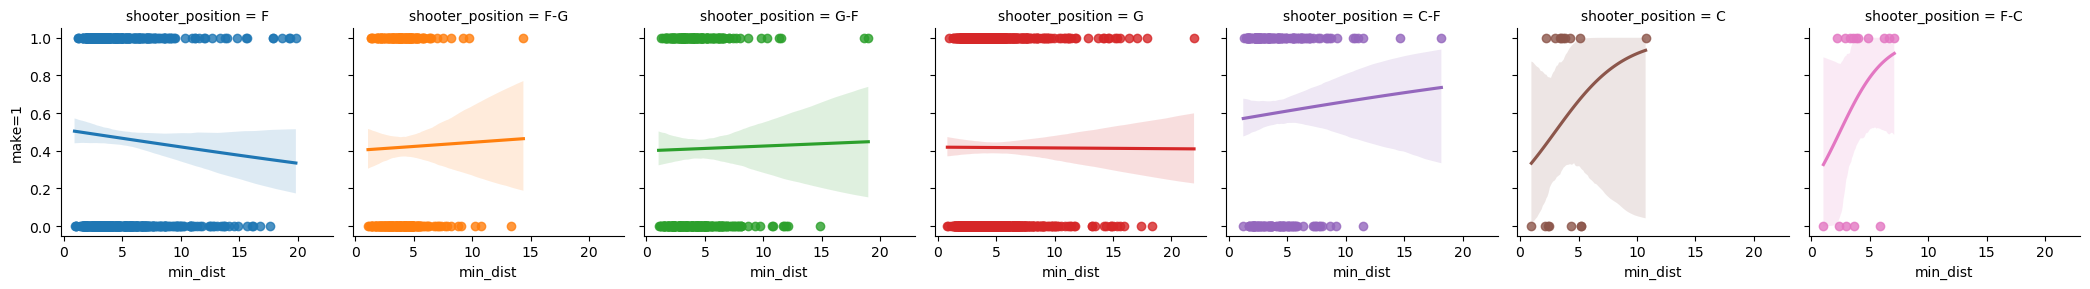

In [197]:
sns.lmplot(x="min_dist", y="make=1", data=all_data, col="shooter_position", hue="shooter_position", height=3, logistic=True)

#center-type players are more likely to make their shots when guarded from farther away, 
#while the reverse can be said about true forwards.

I also ran a logistic regression using shot distance as the x variable.

C:\Users\katvc\anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


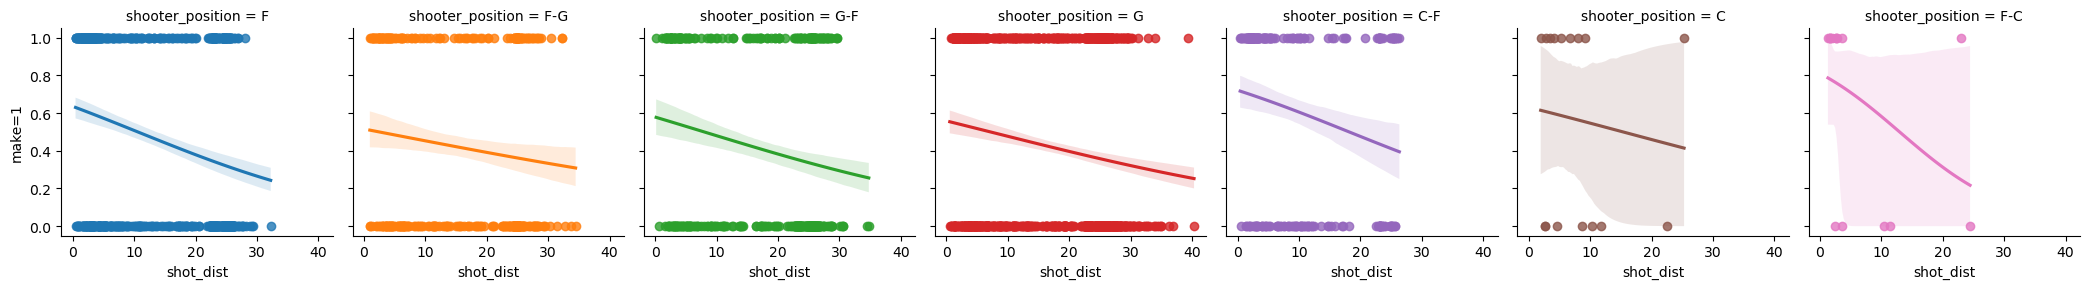

In [196]:
sns.lmplot(x="shot_dist", y="make=1", data=all_data, col="shooter_position", hue="shooter_position", height=3, 
           logistic=True)

#for all players, a further shot is an indication of a less likly to be made shot

## Logistic Regression Model: Training

For the bulk of my statistical data analysis, I wanted to see how well the distance of the closest defender, the shot distance, and the shooter's position predicted the likelihood of a shot being made.

My logistic regression model, that was trained using the data from the all_data dataframe, excluded information from game id 0042100315 (a randomly selected game), which would later become my testing data to investigate the model's accuracy.

In [150]:
#setting my variables
y = all_data[["make=1"]]
X = all_data[["min_dist", "shot_dist", "shooter_position"]]
             
#getting dummy varibles for position (a catergorical variable)
X = pd.get_dummies(data=X, drop_first=True)
display(X.head(1))

#setting my model
model = LogisticRegression()

logreg_model = model.fit(X,y)

print("Model intercept =", model.intercept_)
print("Model coefficients =", model.coef_)

#below are the order of the variables, the model intercept, and the variables coefficients.

,min_dist,shot_dist,shooter_position_C-F,shooter_position_F,shooter_position_F-C,shooter_position_F-G,shooter_position_G,shooter_position_G-F
0,10.932017,24.367047,0,1,0,0,0,0


Model intercept = [0.25695482]
Model coefficients = [[ 0.08982639 -0.0519201   0.30074717 -0.15236263  0.33468265 -0.14663077
  -0.12203925 -0.12748826]]


C:\Users\katvc\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Logistic Regression Model: Testing

To test the accuracy of the model, I gathered the same data from game id "0042100315" that I did from the other games in all_data.

In [153]:
gameid = "0042100315"

test_shots_data = pd.DataFrame({
    'game_id': [],
    'shooter_id': [],
    'shot_time': [],
    "shot_dist": [],
    'min_dist': [],
    'make=1': []
    })

test_events = pd.read_json("0042100315_events.jsonl", lines=True)
test_track = pd.read_json("0042100315_tracking.jsonl", lines=True)
test_pbp = pd.read_json("0042100315_pbp.jsonl")

#1b merge dataframes into one:
    
test_game = pd.merge(pd.merge(test_events,test_track,on='wallClock'),test_pbp,on='wallClock')

#2 filter to obtain only data about shots:
test_game_shots = test_game.loc[test_game.eventType_x=="SHOT"]
with pd.option_context('mode.chained_assignment', None): #error supression
    #below to meant to ease working around [None] dataframe cells
    test_game_shots.HOMEDESCRIPTION.replace(to_replace=[None], value="No Description", inplace=True)
    test_game_shots.VISITORDESCRIPTION.replace(to_replace=[None], value="No Description", inplace=True)
    test_game_shots = test_game_shots.loc[(test_game_shots["EVENTMSGTYPE"]==1) | (test_game_shots["EVENTMSGTYPE"]==2)]
        
#3 retrieve shooter ids, shot times, and shot locations:
    
test_shooter_ids = test_game_shots.playerId_x
test_shot_times = test_game_shots.wallClock
test_shot_locations = test_track.loc[test_track.wallClock.isin(test_shot_times)]
    
#4 determining openness of shot for each shot in game_shots:
    
for shot in range(len(test_game_shots)):
        
#4a getting shooter's location:
        
    test_shooter_loc = "NaN"

    while test_shooter_loc == "NaN":
        for player in range(5):
            if test_shot_locations["awayPlayers"].iloc[shot][player]['playerId'] == test_shooter_ids.iloc[shot]:
                test_shooter_loc = test_shot_locations["awayPlayers"].iloc[shot][player]['xyz']
                test_shooter_team = "away"
        for player in range(5):
            if test_shot_locations["homePlayers"].iloc[shot][player]['playerId'] == test_shooter_ids.iloc[shot]:
                test_shooter_loc = test_shot_locations["homePlayers"].iloc[shot][player]['xyz']
                test_shooter_team = "home"
    
#4b getting defensive player's locations:
        
    test_defense_loc = []

    if test_shooter_team == "home":
        for player in range(5):
            test_defense_loc.append(test_shot_locations["awayPlayers"].iloc[shot][player]['xyz'])
    if test_shooter_team == "away":
        for player in range(5):
            test_defense_loc.append(test_shot_locations["homePlayers"].iloc[shot][player]['xyz'])
        
#4c getting min distance between defense and player:
    
    test_defense_dist = []
        
    for player in range(len(test_defense_loc)):
        d = test_defense_loc[player][0:2]
        s = test_shooter_loc[0:2]
        test_defense_dist.append(math.dist(d,s))
    
    test_min_dist = min(test_defense_dist)
            
#4d getting shot distance
        
    if np.sign(test_shooter_loc[0]) == 1.0:
        h = [41.75,0]
        s = test_shooter_loc[0:2]
        test_shot_dist = math.dist(h,s)
    if np.sign(test_shooter_loc[0]) == -1.0:
        h = [-41.75,0]
        s = test_shooter_loc[0:2]
        test_shot_dist = math.dist(h,s)
        
#5 did the player make the shot?
    
    if test_shooter_team == "home":
        if ("MISS" not in test_game_shots.HOMEDESCRIPTION.iloc[shot]) == True:
            status = 1
        elif ("MISS" not in test_game_shots.HOMEDESCRIPTION.iloc[shot]) == False:
            status = 0
    elif test_shooter_team == "away":
        if ("MISS" not in test_game_shots.VISITORDESCRIPTION.iloc[shot]) == True:
            status = 1
        elif ("MISS" not in test_game_shots.VISITORDESCRIPTION.iloc[shot]) == False:
            status = 0
            
    #6 add data to table:
    test_shots_data.loc[len(test_shots_data.index)] = [gameid, shooter_ids.iloc[shot], test_shot_times.iloc[shot], test_shot_dist, test_min_dist, status]
    
test_shots_data

,game_id,shooter_id,shot_time,shot_dist,min_dist,make=1
0,0042100315,561048bb-c412-4d8b-a0bc-27d250a1a431,1653613441159,1.777751,2.784547,1
1,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653613461959,4.189714,1.905387,0
2,0042100315,986b713a-b20b-4eb0-919e-c859d0508af7,1653613466759,22.269751,5.556987,1
3,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653613484919,25.265459,10.494084,0
4,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653613490239,2.410747,1.565439,1
...,...,...,...,...,...,...
165,0042100315,267de25c-42a5-403a-9fde-0be582ac053b,1653621374559,25.625419,5.226031,1
166,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653621455639,5.453999,4.257347,1
167,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653621464759,24.713917,5.590036,0
168,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653621552999,3.487377,2.420331,0


In [154]:
test_shots_data["game_id"] = test_shots_data["game_id"].apply(str)

#getting the player id for each shot
shooter_ids = test_shots_data.shooter_id

#creating columns for information needed
test_shots_data["shooter_position"] = "NaN"
test_shots_data["shooter_height"] = "NaN"
test_shots_data["shooter_last"] = "NaN"
test_shots_data["shooter_first"] = "NaN"

#match each shooter id to the appropriate information found in the players dataframe, and add to all_data:
for shooter in range(len(shooter_ids)):
    for row in range(len(players)):
        if (shooter_ids.iloc[shooter] in players.iloc[row,0]["id"]) == True:
            with pd.option_context('mode.chained_assignment', None): #error supression
                test_shots_data["shooter_position"].iloc[shooter] = players.iloc[row,0]["position"]
                test_shots_data["shooter_height"].iloc[shooter] = players.iloc[row,0]["height"]
                test_shots_data["shooter_last"].iloc[shooter] = players.iloc[row,0]["lastName"]
                test_shots_data["shooter_first"].iloc[shooter] = players.iloc[row,0]["firstName"]

#for stat purposes
test_shots_data["shooter_height"] = test_shots_data["shooter_height"].apply(pd.to_numeric)

#results
display(test_shots_data.head())
print(test_shots_data.shape)

,game_id,shooter_id,shot_time,shot_dist,min_dist,make=1,shooter_position,shooter_height,shooter_last,shooter_first
0,0042100315,561048bb-c412-4d8b-a0bc-27d250a1a431,1653613441159,1.777751,2.784547,1,F,78.0,Williams,Grant
1,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653613461959,4.189714,1.905387,0,F,77.0,Tucker,P.J.
2,0042100315,986b713a-b20b-4eb0-919e-c859d0508af7,1653613466759,22.269751,5.556987,1,F-G,80.0,Tatum,Jayson
3,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653613484919,25.265459,10.494084,0,F,79.0,Butler,Jimmy
4,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653613490239,2.410747,1.565439,1,G-F,78.0,Brown,Jaylen


(170, 10)


Then, I ran the test variables through the trained model. I added columns to the test data that reflected the predicted shot status (0 = miss, 1 = make) and a column that reflected whether or not the prediction matched the actual shot status.

In [155]:
test_X = pd.get_dummies(data=test_shots_data[["min_dist", "shot_dist", "shooter_position"]], drop_first=True)
y_pred = model.predict(test_X)
test_shots_data["predicted"] = y_pred
test_shots_data["accurate=true"] = (test_shots_data["predicted"]==test_shots_data["make=1"])
test_shots_data

,game_id,shooter_id,shot_time,shot_dist,min_dist,make=1,shooter_position,shooter_height,shooter_last,shooter_first,predicted,accurate=true
0,0042100315,561048bb-c412-4d8b-a0bc-27d250a1a431,1653613441159,1.777751,2.784547,1,F,78.0,Williams,Grant,1,True
1,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653613461959,4.189714,1.905387,0,F,77.0,Tucker,P.J.,1,False
2,0042100315,986b713a-b20b-4eb0-919e-c859d0508af7,1653613466759,22.269751,5.556987,1,F-G,80.0,Tatum,Jayson,0,False
3,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653613484919,25.265459,10.494084,0,F,79.0,Butler,Jimmy,0,True
4,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653613490239,2.410747,1.565439,1,G-F,78.0,Brown,Jaylen,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
165,0042100315,267de25c-42a5-403a-9fde-0be582ac053b,1653621374559,25.625419,5.226031,1,G-F,77.0,Strus,Max,0,False
166,0042100315,a6904c1c-0dc5-41c8-a618-b3a276131726,1653621455639,5.453999,4.257347,1,G-F,78.0,Brown,Jaylen,1,True
167,0042100315,ff41362b-89ef-11e6-babd-a45e60e298d3,1653621464759,24.713917,5.590036,0,F,77.0,Tucker,P.J.,0,True
168,0042100315,ff41f5c7-89ef-11e6-8f93-a45e60e298d3,1653621552999,3.487377,2.420331,0,F,79.0,Butler,Jimmy,1,False


## Model Accuracy & Analysis

I did a quick calculation to determine how accurate the model was.

In [156]:
sum(test_shots_data["accurate=true"])/len(test_shots_data)

#this model was accurate in prediction whether a shot would be made based on the distance of the 
#closest defender, the shot distance, and the player's position about 60% of the time.

0.5882352941176471

In [157]:
test_shots_data.groupby("shooter_position", as_index = False).agg({"accurate=true":["sum", "count"]})

#similarly, the model was not significantly more successful at predicting the shot status for any particular position.

shooter_position accurate=true      
                             sum count
0                C             3     5
1              C-F             8    14
2                F            25    37
3              F-C             2     5
4              F-G            12    21
5                G            33    56
6              G-F            17    32

Taking a look at the model prediction probabilities, we can see that there weren't many shots where the model was strongly predicting one outcome or another.

In [175]:
predict_proba = pd.DataFrame(model.predict_proba(test_X), columns =["miss", "make"])
predict_proba

,miss,make
0,0.434770,0.565230
1,0.485450,0.514550
2,0.633383,0.366617
3,0.565754,0.434246
4,0.463834,0.536166
...,...,...
165,0.675150,0.324850
166,0.443069,0.556931
167,0.662940,0.337060
168,0.464824,0.535176


Most of the probabilies were closer to the 50-50 mark, with few towards the 70-30 mark and more certain in either direction.

<Axes: ylabel='Count'>

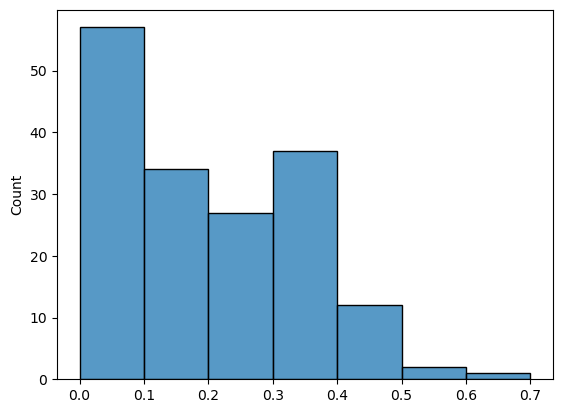

In [178]:
sns.histplot(abs(predict_proba["miss"]-predict_proba["make"]), binwidth= 0.1)

Once we combine the test_shots_data and the predict_proba data, we can also take a look at how changes in the distance of the closest defender are reflected in the probability in the shot being made with a scatterplot with a regression line.

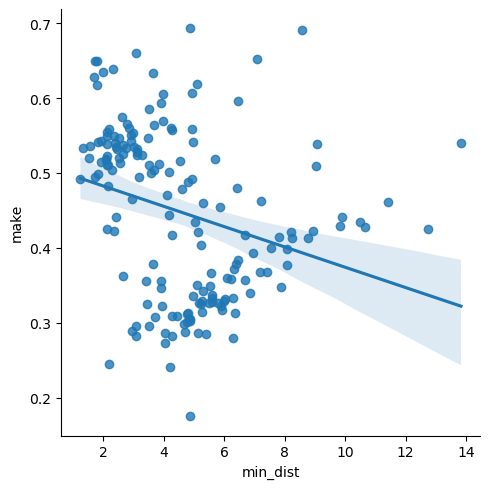

In [190]:
test_shots_data = pd.concat([test_shots_data, predict_proba], axis = 1)
sns.lmplot(x="min_dist", y="make", data=test_shots_data)

#shot probability of a make decreases slightly as the distance of the closest defender increase.

We can also look for the relationship between the changes in the shot distance and the probability of the shot being made.

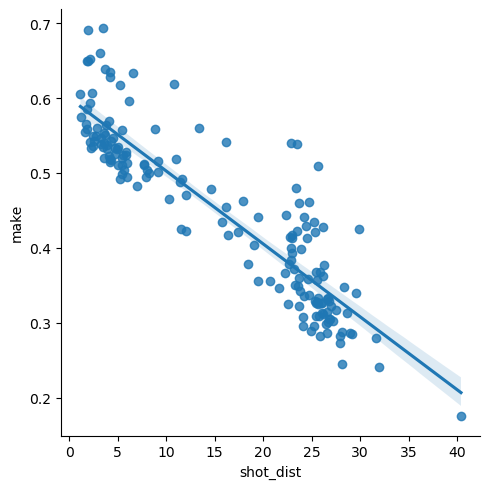

In [191]:
sns.lmplot(x="shot_dist", y="make", data=test_shots_data)

#shot probability of a make decreases significantly as shot distance increases.

# Conclusion

To conclude, the distance of the closest defender, shot distance, and player position tend to be mediocre predicitors of whether or not a player is to make a shot. Most of the predicitions made were not significantly confident.

Shot distance tends to have a stronger negative relationship with the make probability given by the model, while the distance of the closest defender had a weaker negative relationship.

Most notably, earlier logistic regressions conducted between the distance of the closest defender and the shot status per player type bring up some interesting conclusions. (reproduced below)

~ For guard-type and center-type players, as the defenders get farther away, these shooters have insignificant to positive changes in how likely they are to make a shot

~ However, true forwards are less likely to make a shot when they are guarded from farther away.

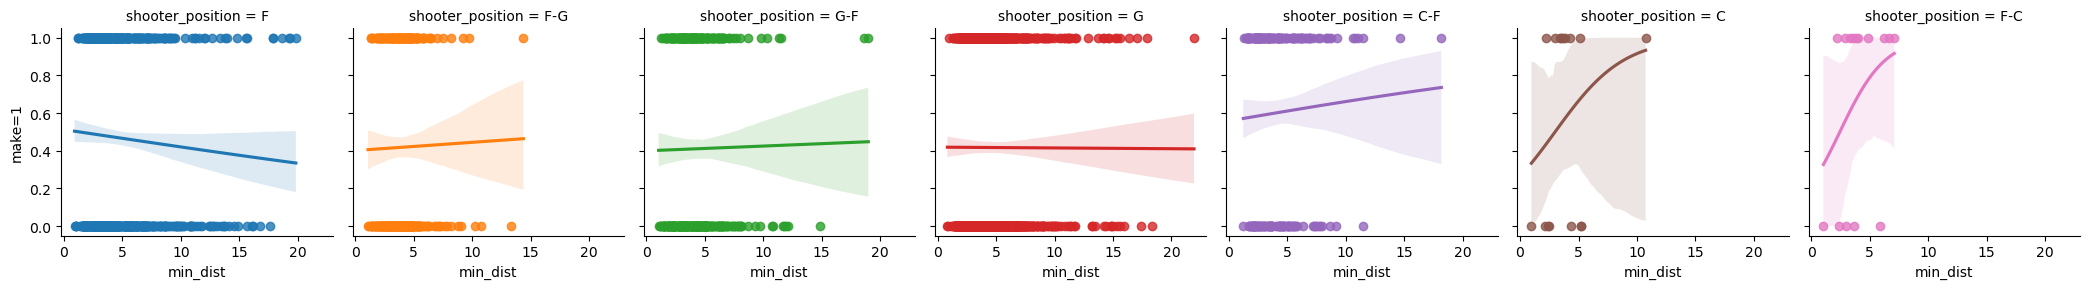

In [195]:
sns.lmplot(x="min_dist", y="make=1", data=all_data, col="shooter_position", hue="shooter_position", height=3, logistic=True)

# Next Steps/Future Recommendations

It may be recommended to pursue further investigations into how forwards can work to become more productive shooters in lower stress, less heavily guarded situations.

Possible relevant factor may include:

~ The shooter's confidence

~ Specific in game timing

~ Specific opponents